<a href="https://colab.research.google.com/github/Tazkia1996/brain-mri-unet/blob/main/brain_mri_segmentation_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation using UNet

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import Libraries

In [4]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import pickle

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Load Data

In [5]:
DataPath = '/content/gdrive/MyDrive/MSC_Thesis/lgg-mri-segmentation/test/sample/'

dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))

In [ ]:
# print(masks[:10], images[:10])

In [6]:
len(dirs), len(images), len(masks)

(302, 302, 302)

In [7]:
imagePath_df = pd.DataFrame({'directory':dirs, 'images': images, 'masks': masks})

In [8]:
imagePath_df.head()

,directory,images,masks
0,TCGA_HT_A61B_19991127,TCGA_HT_A61B_19991127_58.tif,TCGA_HT_A61B_19991127_58_mask.tif
1,TCGA_HT_A61B_19991127,TCGA_HT_A61B_19991127_46.tif,TCGA_HT_A61B_19991127_46_mask.tif
2,TCGA_HT_A61B_19991127,TCGA_HT_A61B_19991127_43.tif,TCGA_HT_A61B_19991127_43_mask.tif
3,TCGA_HT_A61B_19991127,TCGA_HT_A61B_19991127_62.tif,TCGA_HT_A61B_19991127_62_mask.tif
4,TCGA_HT_A61B_19991127,TCGA_HT_A61B_19991127_69.tif,TCGA_HT_A61B_19991127_69_mask.tif


## Image Shape

In [9]:
def print_imShape():
    idx = np.random.randint(0, len(imagePath_df))

    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])

    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    print("Shape of Images ", image.shape)
    print("Shape of Masks ", mask.shape)

In [10]:
for i in range(5):
    print_imShape()

Shape of Images  (256, 256, 3)
Shape of Masks  (256, 256, 3)
Shape of Images  (256, 256, 3)
Shape of Masks  (256, 256, 3)
Shape of Images  (256, 256, 3)
Shape of Masks  (256, 256, 3)
Shape of Images  (256, 256, 3)
Shape of Masks  (256, 256, 3)
Shape of Images  (256, 256, 3)
Shape of Masks  (256, 256, 3)


## Plot Images

In [11]:
def plot_images():
    idx = np.random.randint(0, len(imagePath_df))

    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])

    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)

    fig, axs = plt.subplots(1,3, figsize=[13,15])

    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')

    axs[1].imshow(mask)
    axs[1].set_title('Mask')

    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.3)
    axs[2].set_title('MRI with mask')

    plt.grid(False)
    plt.show()

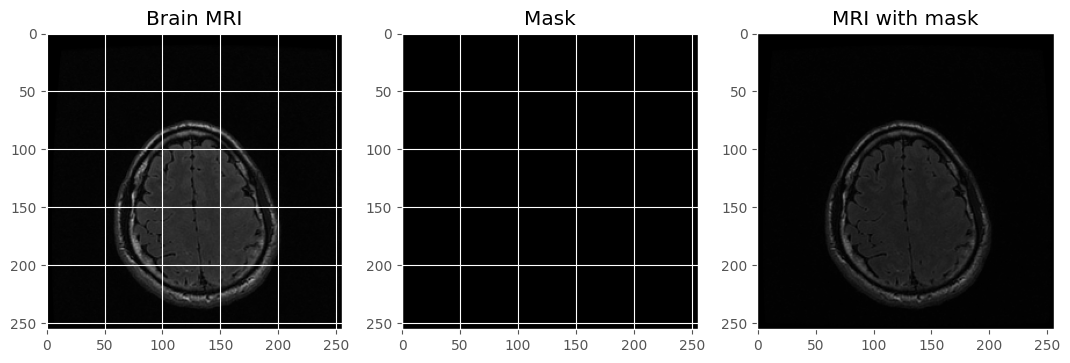

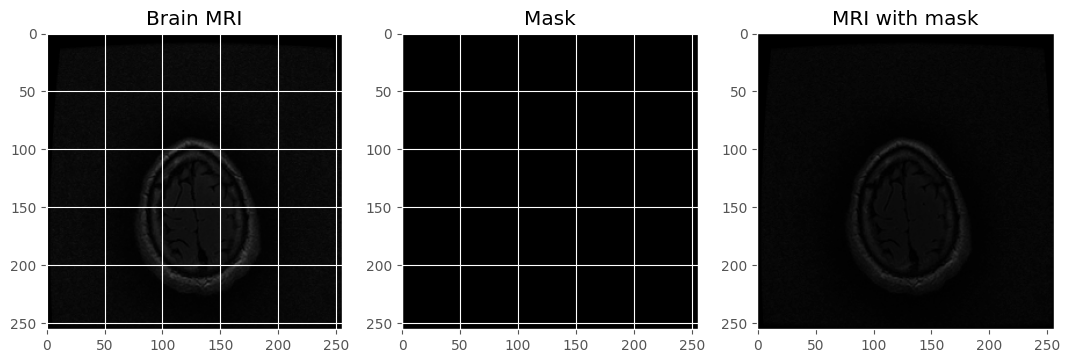

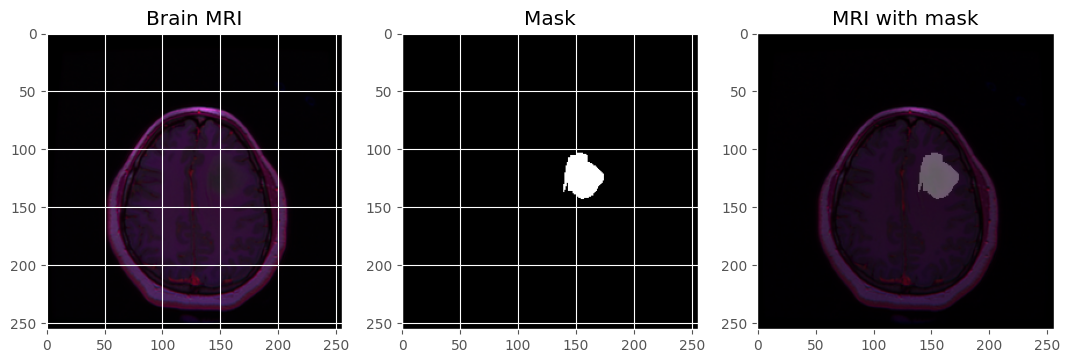

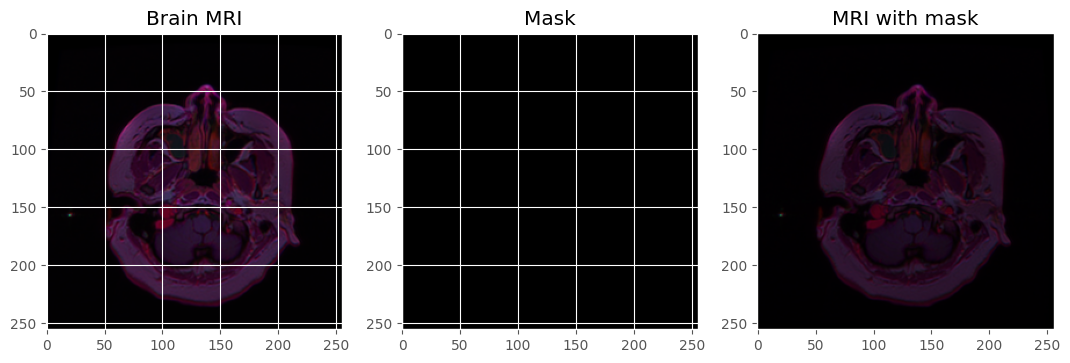

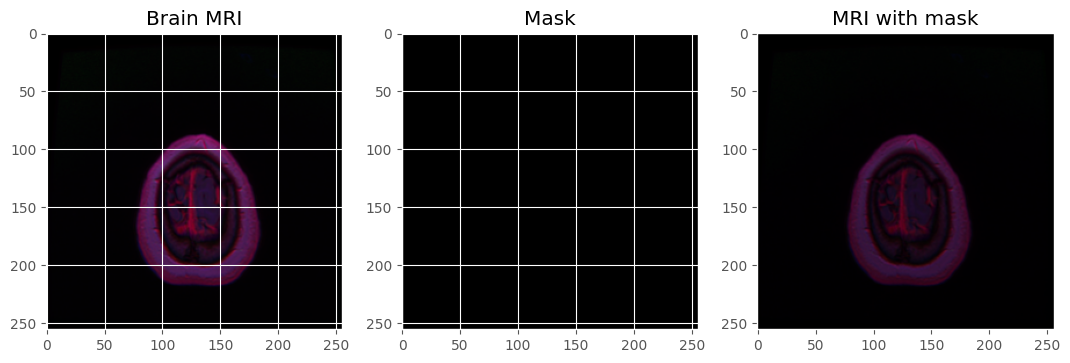

In [12]:
for i in range(5):
    plot_images()

## Config

In [13]:
imagePath_df['image-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['images']
imagePath_df['mask-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['masks']

In [14]:
train , test = train_test_split(imagePath_df, test_size=0.25, random_state=21)

In [16]:
EPOCHS = 30
BATCH_SIZE = 4
ImgHieght = 256
ImgWidth = 256
Channels = 3

## Data Generator

In [17]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

### Train

In [18]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)


# train generator
timage_generator=imagegen.flow_from_dataframe(dataframe=train,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
# mask data generator
tmask_generator=maskgen.flow_from_dataframe(dataframe=train,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')

Found 226 validated image filenames.
Found 226 validated image filenames.


### Validation

In [19]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)


# train generator
vimage_generator=imagegen.flow_from_dataframe(dataframe=test,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
# validation data generator
vmask_generator=maskgen.flow_from_dataframe(dataframe=test,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')

Found 76 validated image filenames.
Found 76 validated image filenames.


In [20]:
def data_iterator(image_gen, mask_gen):
    for img, mask in zip(image_gen, mask_gen):
        yield img, mask

In [21]:
train_gen = data_iterator(timage_generator, tmask_generator)
valid_gen = data_iterator(vimage_generator, vmask_generator)

## UNet

In [22]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [23]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [24]:
input_img = Input((ImgHieght, ImgWidth, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.2, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  448         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

## Train

In [26]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    ModelCheckpoint('model-brain-mri.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [27]:
import math

STEP_SIZE_TRAIN = timage_generator.n/BATCH_SIZE
STEP_SIZE_VALID = vimage_generator.n/BATCH_SIZE
STEP_SIZE_VALID = int(math.ceil(STEP_SIZE_VALID))


print(STEP_SIZE_TRAIN)

print(STEP_SIZE_VALID)

56.5
19


In [ ]:
results = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID)
# save the model to disk
filename = '/content/gdrive/MyDrive/MSC_Thesis/unet2.sav'
pickle.dump(model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))

Epoch 1/30
57/56 [==============================] - ETA: -1s - loss: 0.3603 - accuracy: 0.9416
Epoch 1: val_loss improved from inf to 0.45035, saving model to model-brain-mri.h5
56/56 [==============================] - 200s 3s/step - loss: 0.3603 - accuracy: 0.9416 - val_loss: 0.4503 - val_accuracy: 0.8805 - lr: 0.0010
Epoch 2/30
57/56 [==============================] - ETA: -1s - loss: 0.1749 - accuracy: 0.9906
Epoch 2: val_loss improved from 0.45035 to 0.15954, saving model to model-brain-mri.h5
56/56 [==============================] - 169s 3s/step - loss: 0.1749 - accuracy: 0.9906 - val_loss: 0.1595 - val_accuracy: 0.9889 - lr: 0.0010
Epoch 3/30
57/56 [==============================] - ETA: -1s - loss: 0.1147 - accuracy: 0.9920
Epoch 3: val_loss improved from 0.15954 to 0.11230, saving model to model-brain-mri.h5
56/56 [==============================] - 158s 3s/step - loss: 0.1147 - accuracy: 0.9920 - val_loss: 0.1123 - val_accuracy: 0.9922 - lr: 0.0010
Epoch 4/30
57/56 [===========

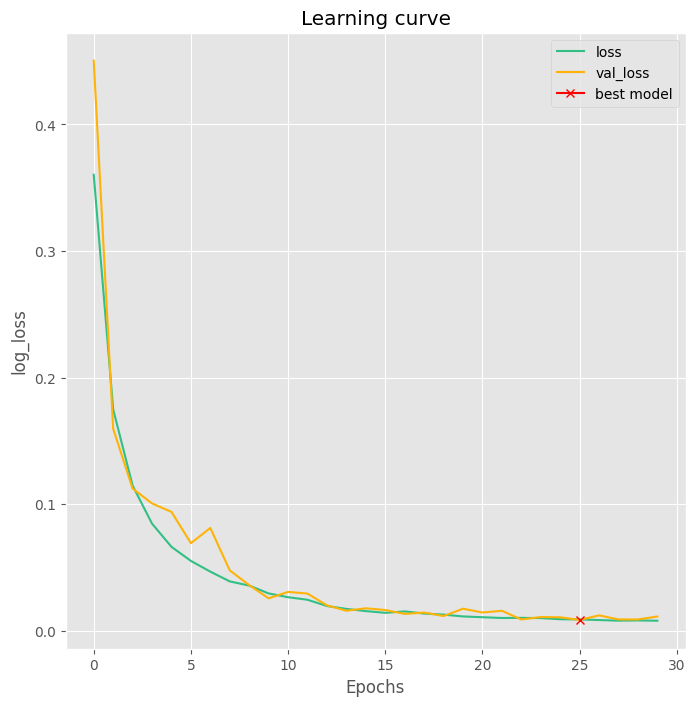

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss", color=sns.xkcd_rgb['greenish teal'])
plt.plot(results.history["val_loss"], label="val_loss", color=sns.xkcd_rgb['amber'])
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
# plt.grid(False)
plt.show()

## Prediction

In [28]:
# load the best model
model=pickle.load(open('/content/gdrive/MyDrive/MSC_Thesis/unet2.sav', 'rb'))
#model.load_weights('model-brain-mri.h5')

In [ ]:
eval_results = model.evaluate(valid_gen, steps=STEP_SIZE_VALID, verbose=1)

19/19 [==============================] - 12s 587ms/step - loss: 0.0114 - accuracy: 0.9960


1/1 [==============================] - 1s 782ms/step


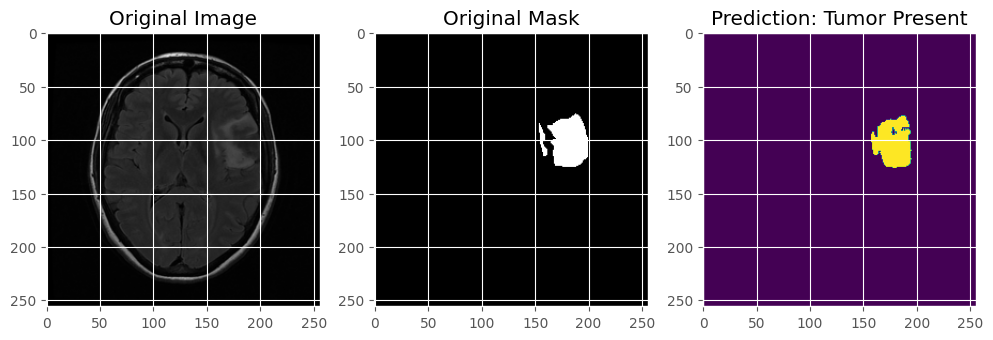

1/1 [==============================] - 0s 138ms/step


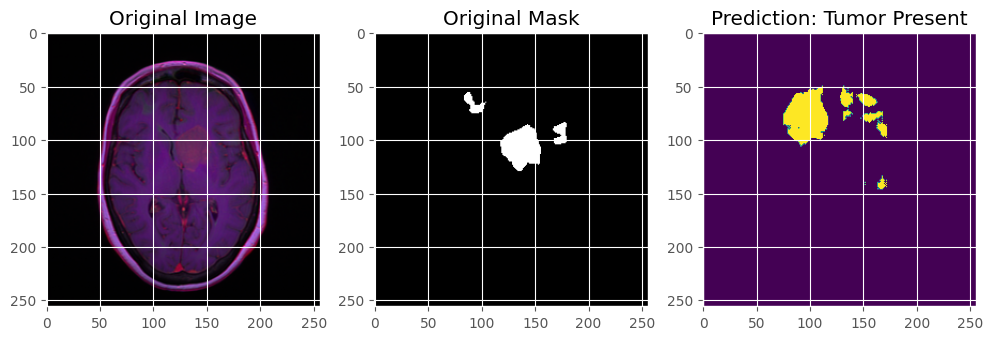

1/1 [==============================] - 0s 155ms/step


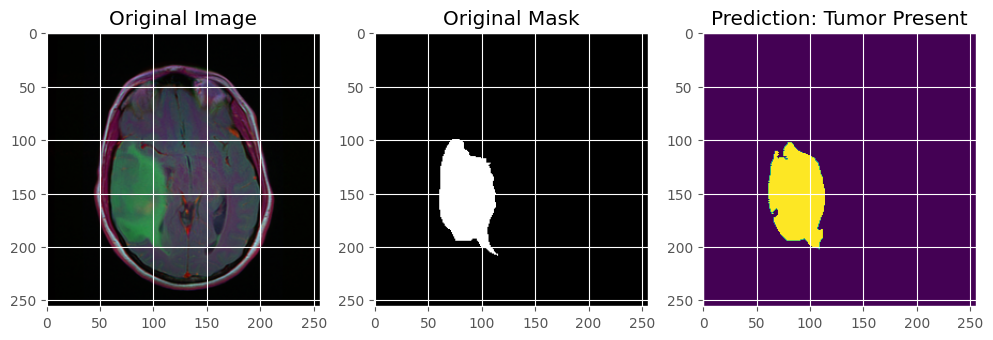

1/1 [==============================] - 0s 136ms/step


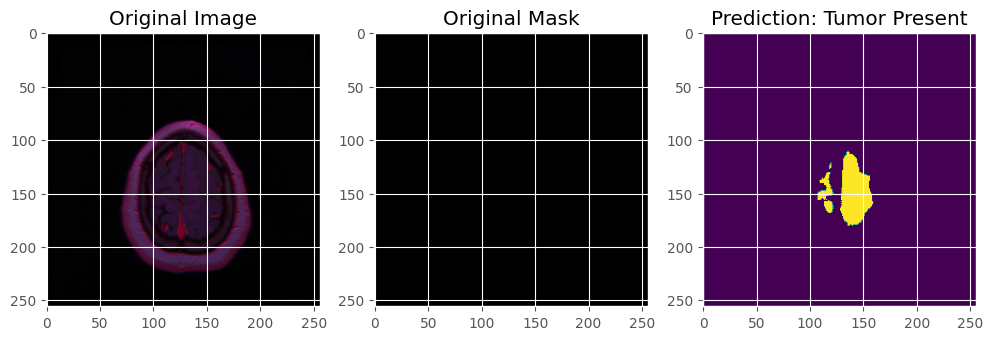

1/1 [==============================] - 0s 395ms/step


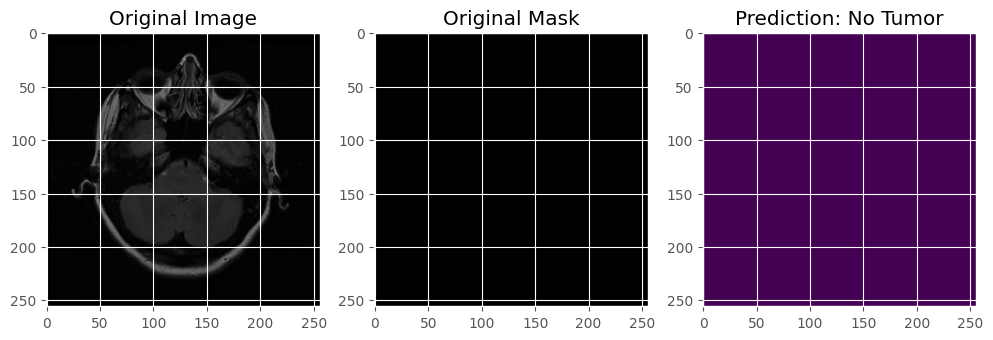

1/1 [==============================] - 0s 256ms/step


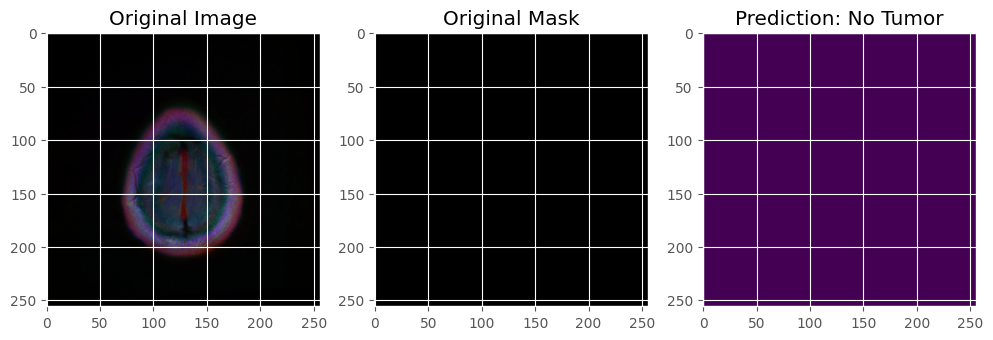

1/1 [==============================] - 0s 250ms/step


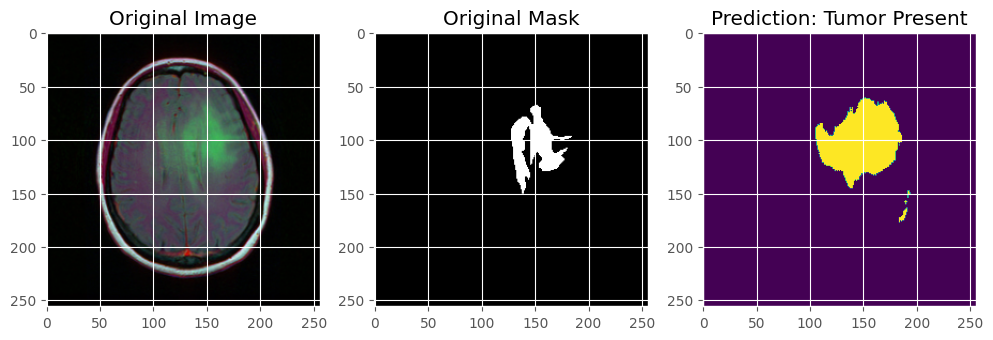

1/1 [==============================] - 0s 169ms/step


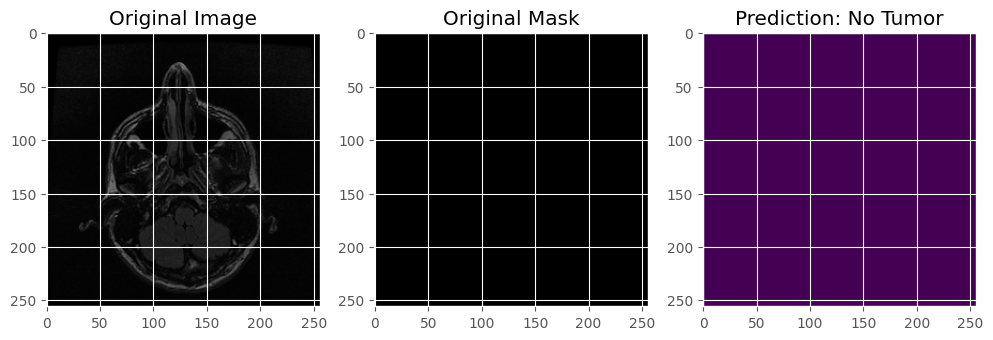

1/1 [==============================] - 0s 149ms/step


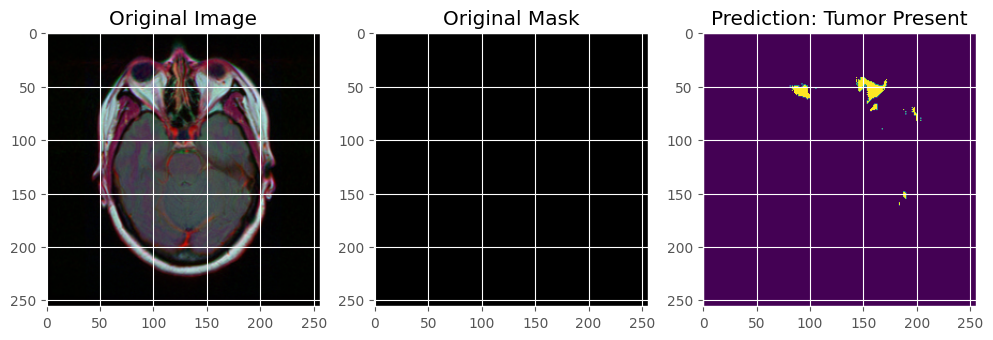

1/1 [==============================] - 0s 137ms/step


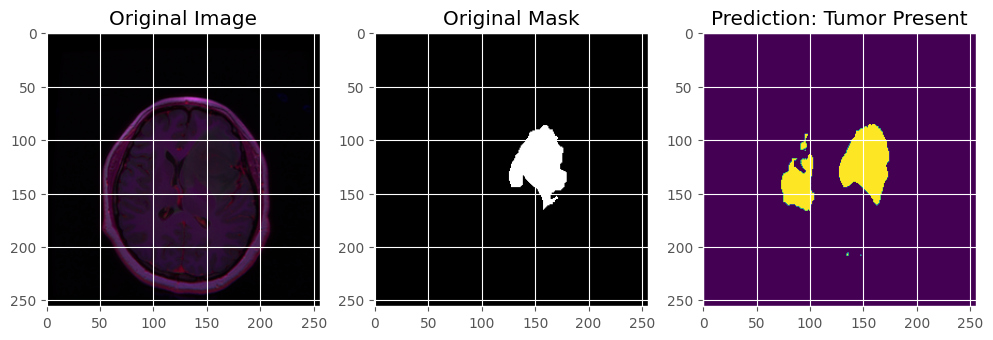

In [29]:
for i in range(10):
    idx = np.random.randint(0, len(imagePath_df))

    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])

    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)

    img = cv2.resize(image ,(ImgHieght, ImgWidth))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.title('Original Mask')
 #   plt.subplot(1,3,3)
 #   plt.imshow(np.squeeze(pred))
  #  plt.title('Prediction')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > 0.5)
    if (np.squeeze(pred) > 0.5).any():
      label = "Prediction: Tumor Present"
    else:
      label = "Prediction: No Tumor"
    plt.title(label)

    plt.show()